----

# Sprint 10 - Proyecto. Toma de decisiones de negocio. Test A/B

**Descripción del proyecto**

Contexto.
Eres analista en una gran tienda online. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.

Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

**Descripción de los datos**

Datos utilizados en la primera parte del proyecto

/datasets/hypotheses_us.csv

- Hypotheses: breves descripciones de las hipótesis.
- Reach: alcance del usuario, en una escala del uno a diez.
- Impact: impacto en los usuarios, en una escala del uno al diez.
- Confidence: confianza en la hipótesis, en una escala del uno al diez.
- Effort: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.


Datos utilizados en la segunda parte del proyecto

/datasets/orders_us.csv

- transactionId: identificador de pedido.
- visitorId: identificador del usuario que realizó el pedido.
- date: fecha del pedido.
- revenue: ingresos del pedido.
- group: el grupo del test A/B al que pertenece el usuario.

/datasets/visits_us.csv

- date: la fecha.
- group: grupo de la prueba A/B.
- visits: el número de visitas en la fecha especificada en el grupo de pruebas A/B especificado.


# 1. Limpieza de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
df_hypotheses = pd.read_csv("/datasets/hypotheses_us.csv", sep=";")
df_orders = pd.read_csv("/datasets/orders_us.csv")
df_visits = pd.read_csv("/datasets/visits_us.csv")

In [3]:
df_hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [5]:
df_hypotheses.columns = df_hypotheses.columns.str.lower()

In [6]:
df_hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [7]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [8]:
df_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [9]:
df_orders["date"] = pd.to_datetime(df_orders["date"])

In [10]:
df_orders = df_orders.rename(columns={"transactionId":"transaction_id","visitorId": "visitor_id" })

In [11]:
df_orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [12]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   float64       
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [13]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [14]:
df_visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [15]:
df_visits["date"] = pd.to_datetime(df_visits["date"])

In [16]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


# Parte 1. Priorizar hipótesis

El ejercicio consiste en:

- Aplicar el framework ICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.
- Aplicar el framework RICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.
- Mostrar cómo cambia la priorización de hipótesis cuando utilizas RICE en lugar de ICE. Proporcionar una explicación de los cambios.

In [17]:
df_hypotheses["ICE"] = df_hypotheses["impact"] * df_hypotheses["confidence"] / df_hypotheses["effort"]
df_hypotheses["RICE"] = df_hypotheses["reach"] * df_hypotheses["impact"] * df_hypotheses["confidence"] / df_hypotheses["effort"]

In [18]:
df_hypotheses_ice = df_hypotheses.sort_values(by="ICE", ascending=False)
df_hypotheses_ice

,hypothesis,reach,impact,confidence,effort,ICE,RICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


In [19]:
df_hypotheses_rice = df_hypotheses.sort_values(by="RICE", ascending=False)
df_hypotheses_rice

,hypothesis,reach,impact,confidence,effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


La diferencia entre ambos enfoques de priorización de hipótesis reside en que ICE se concentra principalmente en las propuestas que requieran menos esfuerzo, mientras que RICE también prioriza un menor esfuerzo; pero toma en cuenta el factor de alcance para determinar si la propuesta beneficiará a una buena cantidad de usuarios. 

En la prueba ICE, la propuesta ganadora es "Lanzar una promoción que ofrezca a los usuarios descuentos". Por lo que esta hipótesis tener beneficios inmediatos para los usuarios activos/registrados. Por lo tanto, la promoción de descuentos es una estrategia que no implica un gran esfuerzo para su implementación. Aunque se debe de cuidar sus implicaciones para el margen de beneficio.  

En la prueba RICE, la propuesta con mejor puntuación es "Añadir un formulario de suscripción en todas las páginas principales". Esta propuesta tiene un alcance de 10, por lo que todos los usuarios tanto activos como potenciales se verán afectados por su implementación. Igualmente su puntuación de esfuerzo es intermedio por lo que puede ser una buena propuesta. Sin embargo, aquí se debe de tener precaución en cómo reaccionarán los usuarios al ver un formulario cada vez que entren al sitio o a las páginas principales. 

# Parte 2. Análisis del test A/B

- Asegúrate de preprocesar los datos. Es posible que haya errores en los datasets originales; por ejemplo, algunos de los visitantes podrían haber entrado tanto en el grupo A como en el grupo B.

In [20]:
df_visitor_groups = df_orders.groupby(["visitor_id", "date"])["group"].nunique().reset_index()
conflicting_visitors = df_visitor_groups[df_visitor_groups["group"] > 1]
conflicting_visitors

,visitor_id,date,group
56,232979603,2019-08-31,2
61,237748145,2019-08-15,2
141,477780734,2019-08-30,2
323,1230306981,2019-08-09,2
342,1316129916,2019-08-27,2
426,1614305549,2019-08-29,2
477,1801183820,2019-08-05,2
530,2038680547,2019-08-04,2
624,2378935119,2019-08-10,2
653,2458001652,2019-08-06,2


In [21]:
df_orders = df_orders[~df_orders["visitor_id"].isin(conflicting_visitors["visitor_id"])]
df_orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [22]:
df_visitor_groups_review = df_orders.groupby(["visitor_id", "date"])["group"].nunique().reset_index()
conflicting_visitors_review = df_visitor_groups_review[df_visitor_groups_review["group"] > 1]
conflicting_visitors_review

,visitor_id,date,group


In [23]:
df_orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


- Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

In [24]:
datesGroups = df_orders[["date","group"]].drop_duplicates()
ordersAggregated = datesGroups.apply(
                                lambda x: df_orders[np.logical_and(df_orders["date"] <= x["date"], 
                                df_orders["group"] == x["group"])].agg(
                                {"date": "max", "group": "max", "transaction_id": 
                                 pd.Series.nunique, "visitor_id": pd.Series.nunique, "revenue": 
                                "sum"}), axis=1).sort_values(by=["date","group"])


In [25]:
visitorsAggregated = datesGroups.apply(lambda x: df_visits[np.logical_and(df_visits["date"] <= x["date"], 
                     df_visits["group"] == x["group"])].agg( {"date": "max", "group": "max", "visits": "sum"}), 
                     axis=1).sort_values(by=["date","group"])

In [26]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=["date", "group"], right_on=["date", "group"])
cumulativeData.columns = ["date", "group", "orders", "buyers", "revenue", "visitors"]
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,19,19,1258.8,713
2,2019-08-02,A,43,37,3770.1,1338
3,2019-08-02,B,43,42,3882.6,1294
4,2019-08-03,A,67,61,5585.3,1845
...,...,...,...,...,...,...
57,2019-08-29,B,554,524,78801.1,17708
58,2019-08-30,A,499,471,57133.5,18037
59,2019-08-30,B,576,545,82123.7,18198
60,2019-08-31,A,509,480,58038.5,18736


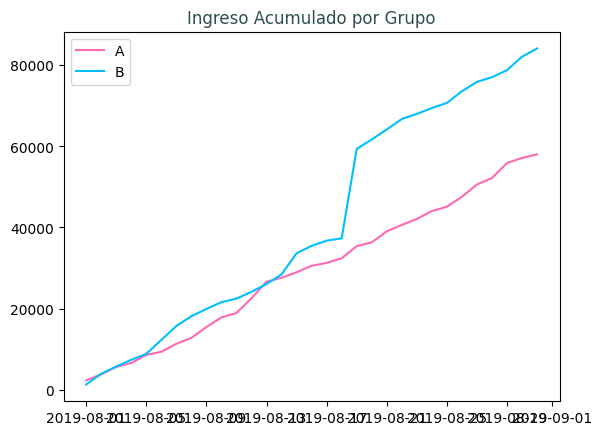

In [27]:
cumulativeRevenueA = cumulativeData[cumulativeData["group"]=="A"][["date","revenue", "orders"]]
cumulativeRevenueB = cumulativeData[cumulativeData["group"]=="B"][["date","revenue", "orders"]]
plt.plot(cumulativeRevenueA["date"], cumulativeRevenueA["revenue"], label="A", color="hotpink")
plt.plot(cumulativeRevenueB["date"], cumulativeRevenueB["revenue"], label="B", color="deepskyblue")
plt.title("Ingreso Acumulado por Grupo", color="darkslategray")
plt.legend()


La prueba que se llevó a cabo durante todo agosto nos muestra que ambos grupos tuvieron un comportamiento casi paralelo hasta la mitad de la prueba. Sin embargo, el grupo B tiene un gran aumento en su ingreso acumulado con una diferencia de casi 30,000 contra el grupo A. Al final de la prueba el grupo B acumuló más de 80,000 comparado con los casi 58,000 del grupo A. 

- Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

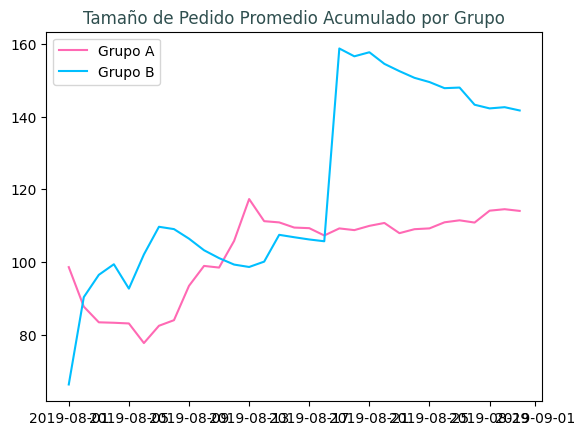

In [28]:
cumulativeRevenueA["avgOrderSizeA"] = cumulativeRevenueA["revenue"] / cumulativeRevenueA["orders"]
cumulativeRevenueB["avgOrderSizeB"] = cumulativeRevenueB["revenue"] / cumulativeRevenueB["orders"]

plt.plot(cumulativeRevenueA["date"], cumulativeRevenueA["avgOrderSizeA"], label="Grupo A", color="hotpink")
plt.plot(cumulativeRevenueB["date"], cumulativeRevenueB["avgOrderSizeB"], label="Grupo B", color="deepskyblue")


plt.title("Tamaño de Pedido Promedio Acumulado por Grupo", color="darkslategray")
plt.legend()


Para el tamaño promedio de los pedidos ambos grupos presentan comportamientos particulares que los diferencia bastante durante el transcurso de la prueba. Para ell grupo A empiezan con una cantidad considerable de pedidos, sin embargo hasta a mediados del mes presentan una baja gradual, de 100 a casi menos de 80 pedidos. Después de la mitad de mes, aumentan los pedidos hasta casi 120 la cual sería la mayor cantidad de pedidos que realiza este grupo. Después de ese punto mantienen una constante de aproximadamente 110 pedidos. 

Para el grupo B empiezan con menos de 60 pedidos, pero en los primeros días la prueba es efectiva sobre este grupo ya que sus pedidos aumentan a 100 y a mediados de mes suben hasta 160 pedidos con un leve descenso a aproximadamente 150 pedidos en promedio para este grupo.

Por lo tanto, la prueba sobre el grupo B muestra una gran efectividad en lograr que los usuarios coloquen más pedidos a difrencia del grupo A. 

- Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia.

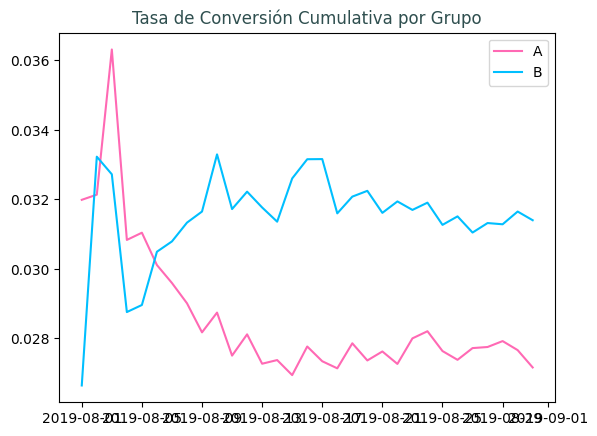

In [29]:
cumulativeData["conversion"] = cumulativeData["orders"]/cumulativeData["visitors"]
cumulativeDataA = cumulativeData[cumulativeData["group"]=="A"]
cumulativeDataB = cumulativeData[cumulativeData["group"]=="B"]
plt.plot(cumulativeDataA["date"], cumulativeDataA["conversion"], label="A", color="hotpink")
plt.plot(cumulativeDataB["date"], cumulativeDataB["conversion"], label="B", color="deepskyblue")
plt.title("Tasa de Conversión Cumulativa por Grupo", color="darkslategray")
plt.legend()  


La tasa de conversión nos muestra la misma efectividad que tuvo la prueba sobre el grupo B, en donde la conversión se mantiene baja al principio, pero a los pocos días de la prueba hay una conversión que pasó del 0.020 al 0.032 de manera abrupta. A pesar de que después tiene una caída, la tasa de conversión se mantiene estable entre 0.033 a 0.030. 

Mientras que para el grupo A la tasa de conversión empieza alta con 0.036; pero disminuye considerablmente en el transcurso del mes con una tasa entre el 0.029 al 0.025. 

A pesar de que el grupo B no consigue la alta tasa de conversión inicial del grupo A del 0.036, este se mantiene mucha más interacción e interés de los usuarios por realizar una compra. 

- Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.

In [30]:
ordersByUsers = (
    df_orders.groupby("visitor_id", as_index=False)
    .agg({"transaction_id": pd.Series.nunique}))

ordersByUsers.columns = ["userId", "orders"]

ordersByUsers.sort_values(by="orders", ascending=False)

,userId,orders
899,3803269165,5
44,199603092,5
112,457167155,4
416,1738359350,3
483,2044997962,3
...,...,...
349,1471458381,1
350,1471496742,1
351,1474473704,1
352,1476256851,1


Text(0.5, 1.0, 'Dispersión del número de pedidos por usuario')

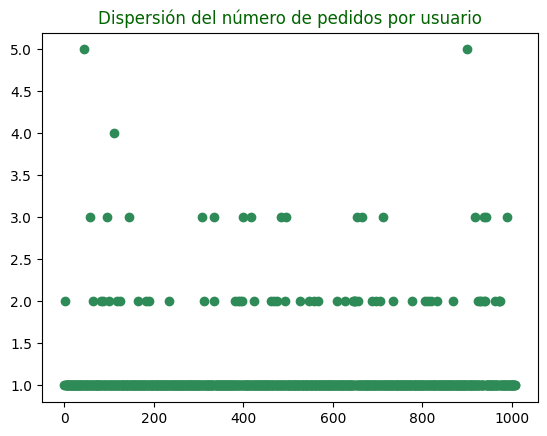

In [31]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers["orders"], color="seagreen")
plt.title("Dispersión del número de pedidos por usuario", color="darkgreen")

La mayoría de los datos se concentra en solo un pedido. Esta cantidad va disminuyenndo considerablemente, siendo solo el máximo de pedidos solo cinco. 

- Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [32]:
orders_95per = np.percentile(ordersByUsers["orders"], 95)
orders_99per = np.percentile(ordersByUsers["orders"], 99)
print(f"No más del 5% de los pedidos fueron de: {orders_95per}")
print(f"No más del 1% de los pedidos fueron de: {orders_99per}")

No más del 5% de los pedidos fueron de: 2.0
No más del 1% de los pedidos fueron de: 3.0


- Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.

Text(0.5, 1.0, 'Dispersión de los precios de los pedidos')

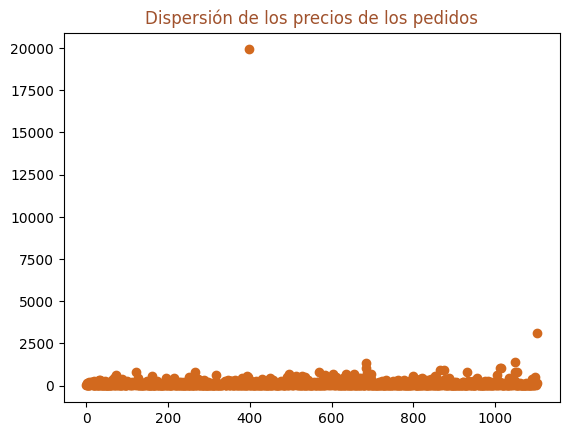

In [33]:
x_values = pd.Series(range(0, len(df_orders["revenue"])))
plt.scatter(x_values, df_orders["revenue"], color="chocolate")
plt.title("Dispersión de los precios de los pedidos", color="sienna")

Los precios de los pedidos se concentran en menos de 2,000, con solo muy pocos datos atípicos de pedidos por 20,000. 

- Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [34]:
revenue_95per = np.percentile(df_orders["revenue"], 95)
revenue_99per = np.percentile(df_orders["revenue"], 99)
print(f"No más del 5% de los pedidos fueron de: {revenue_95per}")
print(f"No más del 1% de los pedidos fueron de: {revenue_99per}")

No más del 5% de los pedidos fueron de: 419.13999999999874
No más del 1% de los pedidos fueron de: 830.0100000000002


- Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [35]:
ordersByUsersA = df_orders[df_orders["group"] == "A"].groupby("visitor_id", as_index=False).agg({"transaction_id" : pd.Series.nunique})
ordersByUsersA.columns = ["userId", "orders"]
ordersByUsersB = df_orders[df_orders["group"] == "B"].groupby("visitor_id", as_index=False).agg({"transaction_id" : pd.Series.nunique})
ordersByUsersB.columns = ["userId", "orders"]

In [36]:
pd.Series(0, index=np.arange(df_visits[df_visits["group"] == "A"]["visits"].sum() - 
                             len(ordersByUsersA["orders"])), name="orders")

0        0
1        0
2        0
3        0
4        0
        ..
18251    0
18252    0
18253    0
18254    0
18255    0
Name: orders, Length: 18256, dtype: int64

In [37]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(df_visits[df_visits['group']=='A']['visits'].sum() - 
                                                       len(ordersByUsersA['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 475    1
 476    1
 477    1
 478    1
 479    1
 Name: orders, Length: 480, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18251    0
 18252    0
 18253    0
 18254    0
 18255    0
 Name: orders, Length: 18256, dtype: int64]

In [38]:
sampleA = pd.concat([ordersByUsersA["orders"], pd.Series(0, index=np.arange(df_visits[df_visits["group"] == "A"]["visits"].sum() - len(ordersByUsersA["orders"])), name="orders")], axis=0)
sampleB = pd.concat([ordersByUsersB["orders"], pd.Series(0, index=np.arange(df_visits[df_visits["group"] == "B"]["visits"].sum() - len(ordersByUsersB["orders"])), name="orders")], axis=0)


In [39]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.014


A partir de los datos brutos, la diferencia de la conversión entre los grupos es de 0.014, por lo tanto, sí hay una diferencia entre los grupos A y B. Esto se puede demostrar en la gráfica de la tasa de conversión en donde el grupo B mostró una mayor efectividad en la conversión. 

- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [40]:
print("{0:.3f}".format(stats.mannwhitneyu(df_orders[df_orders["group"] == "A"]["revenue"], 
                                          df_orders[df_orders["group"] == "B"]["revenue"])[1]))

0.653


A partir de los datos brutos, la salida del valor p es de 0.653, por lo tanto en cuanto al promedio de pedidos no es significativa entre ambos grupos. 

- Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [41]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA["orders"] > 2]["userId"], ordersByUsersB[ordersByUsersB["orders"] > 2]["userId"]], axis=0)
usersWithExpensiveOrders = df_orders[df_orders["revenue"] > 420]["visitor_id"]
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

print(f"El número de usuarios anómalos es de: {abnormalUsers.shape}")

El número de usuarios anómalos es de: (66,)


In [42]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA["userId"].isin(abnormalUsers))]["orders"], pd.Series(0, index=np.arange(df_visits[df_visits["group"] == "A"]["visits"].sum() - len(ordersByUsersA["orders"])), name="orders")], axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB["userId"].isin(abnormalUsers))]["orders"], pd.Series(0, index=np.arange(df_visits[df_visits["group"] == "B"]["visits"].sum() - len(ordersByUsersB["orders"])), name="orders")], axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))



0.015


Para los datos filtrados, la diferencia no es considerable comparada con la de los datos brutos. Por lo que aún se eude concluir que la tasa de conversión del grupo B es diferente a la del grupo A. 

- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [43]:
print("{0:.3f}".format(stats.mannwhitneyu(
                        df_orders[np.logical_and(
                        df_orders["group"] == "A", np.logical_not(df_orders["visitor_id"].isin(abnormalUsers)))]["revenue"],  
                        df_orders[np.logical_and(df_orders["group"] == "B",  
                        np.logical_not(df_orders["visitor_id"].isin(abnormalUsers)))]["revenue"])[1])) 


0.576


A partir de los datos filtrados, disminuye un poco la diferencia del promedio de pedidos entre ambos grupos. Sin embargo, aún se concluye que no es significativa dicha diferencia. 

- Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 
   - 1. Parar la prueba, considerar a uno de los grupos como líder. 
   - 2. Parar la prueba, concluir que no hay diferencia entre los grupos. 
   - 3. Continuar la prueba.

Se optaría por la decisión 3 en cuanto a que no hay una diferencia entre la cantidad de pedidos del grupo A y B. Esto debido a que a pesar de que la tasa de conversión muestra una diferencia significativa, al revisar la significancia estadística en cuanto al promedio de pedidos no se demuestran diferencia entre ambos grupos. Igualmente el valor de p con datos brutos y filtrados nos muestra que no hay una diferencia entre ambos grupos. 

Por lo tanto, aunque hay una mayor tasa de conversión en el grupo A, la cantidad absoluta de pedidos no varía de manera significativa entre ambos grupos. Esto puede sugerir que otros factores, como el valor del pedido o la frecuencia de compra, podrían influir son en la variable de conversión, pero no necesariamente en el número total de pedidos.